# Final Model Development and Training

In this Jupyter Notebook, you will develop and train the model for the final model (chosen from 'notebook - prototype' jupyter notebook).

**The content in this notebook will be used to make the recommendation system work in the StreamLit front-end (tentative).**

As stated in 'notebook - prototype' jupyter notebook, the optimal choice (for now) will be the KMeans model.

#### Recommendation A/B Testing: Experimentation with Imperfect Compliance

An online business would like to test a new feature or offering of their website and learn its effect on downstream revenue. Furthermore, they would like to know which kind of users respond best to the new version. We call the user-specfic effect a **heterogeneous treatment effect**. 

Ideally, the business would run an A/B tests between the old and new versions of the website. However, a direct A/B test might not work because the business cannot force the customers to take the new offering. Measuring the effect in this way will be misleading since not every customer exposed to the new offering will take it.

The business also cannot look directly at existing data as it will be biased: the users who use the latest website features are most likely the ones who are very engaged on the website and hence spend more on the company's products to begin with. Estimating the effect this way would be overly optimistic.

**tools from the [EconML](https://aka.ms/econml) library can still use a direct A/B test and mitigate these shortcomings.**

For A/B Testing, source: https://github.com/py-why/EconML/blob/main/notebooks/CustomerScenarios/Case%20Study%20-%20Recommendation%20AB%20Testing%20at%20An%20Online%20Travel%20Company.ipynb

NOTE: EconML only works if you downgrade the python version to 3.10.

Locally, I have changed the kernel environment to .conda (Python 3.10.16)

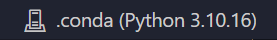

In [1]:
   !pip install pandas psycopg2 scikit-learn torch missingno seaborn matplotlib econml

  Using cached psycopg2-2.9.10-cp310-cp310-win_amd64.whl.metadata (5.0 kB)
  Using cached torch-2.7.0-cp310-cp310-win_amd64.whl.metadata (29 kB)
  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.0-cp310-cp310-win_amd64.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp310-cp310-win_amd64.whl.metadata (9.1 kB)
  Using cached sparse-0.1

In [2]:
### Importing...
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import missingno as msno
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Grabbing the Data and Cleaning it to merged_df

#### Connecting PostGreSQL database

Note: run docker before running the following codes, or tlse it wont work

In [4]:
# reads the whole API
conn2 = ps.connect(dbname = "postgres",
                   user = "postgres",
                   password = "postgres",
                   host = "localhost",
                   port = "5432")

In [5]:
# connect area table
area_sql = """select * 
fROM public.area"""

# connect farm table
farm_sql = """select * 
fROM public.farm"""

# connect product table
product_sql = """select * 
fROM public.product"""

# connect sale_order table
so_sql = """select * 
fROM public.sale_order"""

# connect sale_order_item table
soi_sql = """select * 
fROM public.sale_order_item"""

# connect feedback table
feedback_sql = """select *
fROM public.feedback"""

# connect product_clicks table
product_clicks_sql = """select *
fROM public.product_clicks"""

# connect user_session table
user_session_sql = """select *
fROM public.user_session"""

In [6]:
# read area table
area_df = sqlio.read_sql_query(area_sql, conn2)

# read farm table
farm_df = sqlio.read_sql_query(farm_sql, conn2)

# read product table
product_df = sqlio.read_sql_query(product_sql, conn2)

# read sale_order table
so_df = sqlio.read_sql_query(so_sql, conn2)

# read sale_order_item table
soi_df = sqlio.read_sql_query(soi_sql, conn2)

# read feedback table
feedback_df = sqlio.read_sql_query(feedback_sql, conn2)

# read product_clicks table
product_clicks_df = sqlio.read_sql_query(product_clicks_sql, conn2)

# read user_session table
user_session_df = sqlio.read_sql_query(user_session_sql, conn2)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connecti

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### Renaming of columns for easier interpretability

In [8]:
# rename product_df columns
product_df.rename(columns={'id': 'product_id', 'price': 'product_price'}, inplace=True)
product_df.columns

Index(['product_id', 'sku', 'type', 'unit_of_measurement', 'name',
       'product_price', 'description'],
      dtype='object')

In [9]:
# rename soi_df columns
soi_df.rename(columns={'id': 'sale_order_item_id', 'price': 'sale_order_item_price'}, inplace=True)
soi_df.columns

Index(['sale_order_item_id', 'sale_order_id', 'product_id', 'quantity',
       'sale_order_item_price', 'clicked_from_recommendation',
       'click_timestamp'],
      dtype='object')

In [10]:
# rename so_df columns
so_df.rename(columns={'id': 'sale_order_id'}, inplace=True)
so_df.columns

Index(['sale_order_id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

### Merging of Dataframes

In [11]:
merged_data = soi_df.merge(so_df, on='sale_order_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447


In [12]:
merged_data = merged_data.merge(product_df, on='product_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. <p><strong>Deskripsi</strong></p><p><br></p><p>Pupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.</p><p><br></p><p><strong>Manfaat</strong></p><p><br></p><p>Memberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.</p><p><br></p><p><strong>Kandungan dan Spesifikasi</strong></p><p><br></p><p>Fosfor pentoksida 26-28%</p><p><br></p><p><strong>Produk Teruji Lab?</strong> Ya</p>"
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"<p>Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".</p><p>Ukuran All-size (XL)</p>"
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.</p><p><br></p><p><strong><em><u>Manfaat </u></em></strong></p><p>Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.</p><p><br></p><p><strong><em><u>Kandungan dan Spesifikasi </u></em></strong></p><p><br></p><p>Kalium oksida 60%</p><p>Bentuk / Warna: Kristal / Dominan merah</p><p><br></p><p><strong><em><u>Produk Teruji Lab?</u> </em></strong>Ya</p>"
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447,101110603901,GOODS,kg,NPK Phonska Plus 15-15-15 25kg,441142.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc 

In [13]:
def clean_html(raw_html):
    # Remove HTML tags
    clean_text = re.sub(r'<[^>]+>', '', raw_html)
    # Remove leading/trailing whitespaces and normalize spaces
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

# Apply to the 'description' column
merged_data['description'] = merged_data['description'].astype(str).apply(clean_html)

# Preview the cleaned descriptions
merged_data[['description']].head()


,description
0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
1,Topup PLN 100.000 Topup PLN 100.000
2,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
3,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
4,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 15%Fosfor pentoksida 15%Kalium 15%Sulfur 9%Zinc 0,2%Produk Teruji Lab? Ya"


In [14]:
merged_data.head()


,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447,101110603901,GOODS,kg,NPK Phonska Plus 15-15-15 25kg,441142.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 